## Introduction
In this kernel we will use various predictive models to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. In particular we are interested in oversampling technique to handle imbalanced data. There are three datasets. The first dataset gives the amount and type of transaction. The second dataset provides the class(fradulent\non-fradulent) of transaction. And the third one provides the number of transaction done in last 10 hours prior to the transaction and average basket of the user.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix, recall_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('data.csv')
fraude = pd.read_csv('fraude.csv')
hist = pd.read_csv('historique.csv')

## Feature engineering

We will merge this three datasets into one and rename columns to make them shorter.

In [3]:
data = pd.merge(data, hist, on='id_transaction', how='outer')
data = pd.merge(data, fraude, on='id_transaction', how='outer')

In [4]:
data.columns

Index(['id_transaction', 'Montant_transaction', 'Type_transaction',
       'Panier_moyen', 'Nombre_Transactions_10_Dernieres_heures', 'is_fraud'],
      dtype='object')

In [5]:
data = data.rename(columns={
    'Nombre_Transactions_10_Dernieres_heures': 'Nombre', 
    'id_transaction': 'Id', 
    'Montant_transaction': 'Montant',
    'Type_transaction': 'Type', 
    'is_fraud': 'Fraude'
                        }
)
data = data.set_index('Id')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Montant       6000 non-null   float64
 1   Type          6000 non-null   float64
 2   Panier_moyen  4033 non-null   float64
 3   Nombre        4033 non-null   float64
 4   Fraude        6000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 281.2 KB


In [7]:
data.isna().sum()

Montant            0
Type               0
Panier_moyen    1967
Nombre          1967
Fraude             0
dtype: int64

There are missing valus for both 'Panier_moyen' and 'Nombre. The number of samples having missing values is 1967 which is important number compare to the size of our dataset. Later we will see how to impute this values.

Let's give a look to our dataset.

In [8]:
data.head()

,Montant,Type,Panier_moyen,Nombre,Fraude
Id,,,,,
0,80.600541,9.0,70.355644,0.0,0
1,135.300834,9.0,167.572760,0.0,0
2,64.697647,10.0,149.669169,5.0,0
3,129.709763,7.0,131.733207,0.0,0
4,197.145729,9.0,NaN,NaN,0


Let's look at the summary statistics of continuous features of dataset.

In [9]:
data.drop('Type', axis=1).describe()

,Montant,Panier_moyen,Nombre,Fraude
count,6000.000000,4033.000000,4033.000000,6000.000000
mean,135.056571,149.271894,2.912720,0.110000
std,83.650612,49.122507,4.097439,0.312916
min,1.433002,-36.032266,0.000000,0.000000
25%,71.646828,116.857273,0.000000,0.000000
50%,120.250282,149.396301,1.000000,0.000000
75%,183.882505,182.530784,5.000000,0.000000
max,516.179216,307.453916,25.000000,1.000000


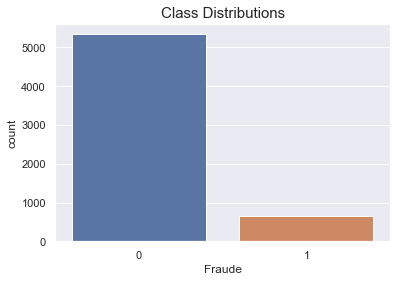

No Frauds 89.00 % of the dataset
Frauds 11.00 % of the dataset


In [10]:
sns.countplot(x='Fraude', data=data)
plt.title('Class Distributions', fontsize=15)
plt.show()

print('No Frauds {:.2f}'.format(data['Fraude']
.value_counts()[0]/len(data) * 100), '% of the dataset')
print('Frauds {:.2f}'.format(data['Fraude']
.value_counts()[1]/len(data) * 100), '% of the dataset')

We have imbalanced data. Let's plot pairwise relationships in a dataset with different levels of our target variable.

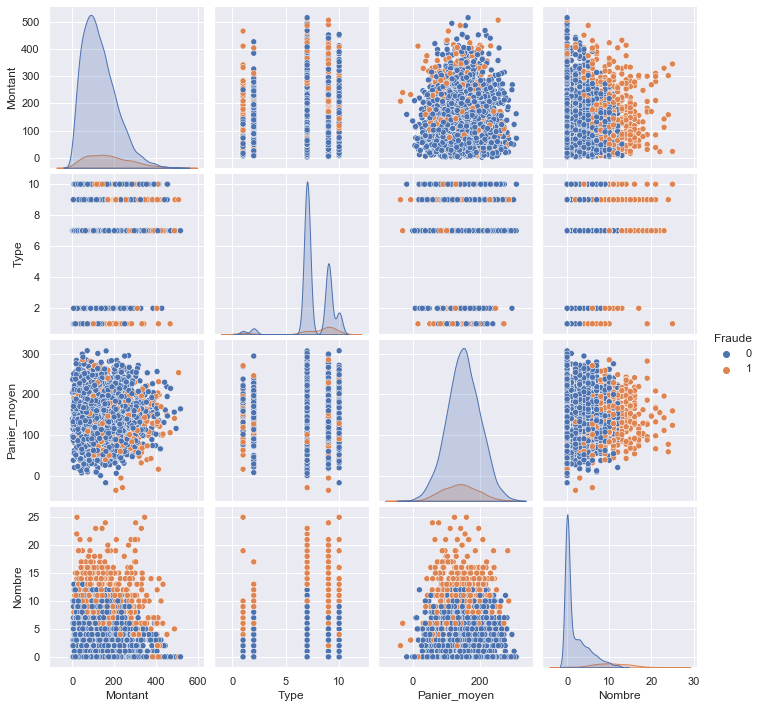

In [11]:
sns.pairplot(data, hue='Fraude')
plt.show()

There is no evident relationships between input variables.

### Quantitatve features

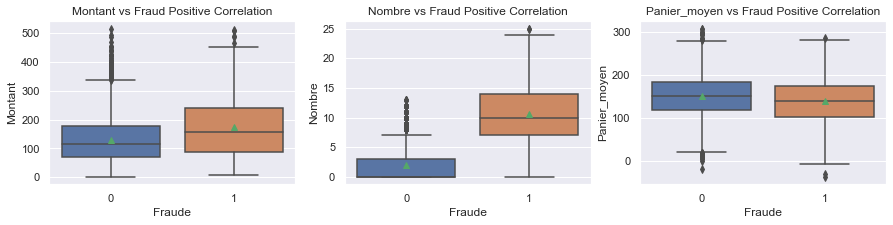

In [12]:
f, axes = plt.subplots(ncols=3, figsize=(15,3))

sns.boxplot(x='Fraude', y='Montant', showmeans=True, data=data, ax=axes[0])
axes[0].set_title('Montant vs Fraud Positive Correlation')

sns.boxplot(x='Fraude', y='Nombre', showmeans=True, data=data, ax=axes[1])
axes[1].set_title('Nombre vs Fraud Positive Correlation')

sns.boxplot(x='Fraude', y='Panier_moyen', showmeans=True, data=data, ax=axes[2])
axes[2].set_title('Panier_moyen vs Fraud Positive Correlation')

plt.show()

We can see that the feature Montant has slightly higher values in fradulent transactions while the feature Nombre is strongly correlated with the nature of transaction.

### Categorical features

In [13]:
data['Type'] = data['Type'].astype(int)

In [14]:
h = open('type_transaction.txt')

In [15]:
print(h.read())

Type transaction |            description             
-----+------------------------------------
  0 | Card-Swiped
  1 | MOTO/Card Not Present
  2 | MOTO/Recurring
  3 | Installment Payment
  4 | Card Present, Manually Keyed
  5 | Secure/Authenticated E-commerce
  6 | Non-Authenticated E-commerce
  7 | E-commerce with SSL/TLS Encryption
  8 | Non-Secure E-Commerce
  9 | Recurring E-commerce
 10 | Point of sale Payment



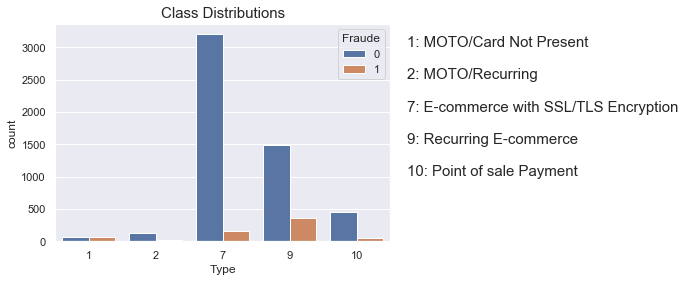

In [16]:
sns.countplot(x='Type', hue='Fraude', data=data)
plt.title('Class Distributions', fontsize=15)
plt.text(1.05, 0.3, 
"""1: MOTO/Card Not Present \n 
2: MOTO/Recurring \n 
7: E-commerce with SSL/TLS Encryption \n 
9: Recurring E-commerce \n 
10: Point of sale Payment""",
        {'fontsize': 15},
         horizontalalignment='left',
         rotation=0,
         clip_on=False,
         transform=plt.gca().transAxes)
plt.show()

We see how the ratio normal/fraud differs from one type of transaction to the other. The most of fradulent transactions are of type recurring E-commerce.

In [17]:
X = data.drop('Fraude',axis=1)
y = data['Fraude']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.2, random_state=42)

#### Imputting missing values, handling categorical attributes and scaling the data

Robust scaler removes the median and scales the data according to the quantile range. We will use k-Nearest Neighbors to imput missing values. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

In [19]:
from sklearn.compose import ColumnTransformer

numeric_features = list(x_train.drop('Type', axis=1))
categorical_features = ['Type']

num_pipeline = Pipeline(steps=[
             ('imputer', KNNImputer(n_neighbors=15, weights="uniform")),
             ('rob_scaler', RobustScaler())])

cat_pipeline = Pipeline(steps=[
             ('one_hot_encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, categorical_features)])

x_train_prepared = preprocessor.fit_transform(x_train)

### Classifiers on the original dataset

* The performance of machine learning algorithms is typically evaluated using predictive accuracy. However, this is not appropriate when the data is imbalanced. A simple default strategy of guessing the majority class would give a predictive accuracy of 89%.

* The Receiver Operating Characteristic (ROC) curve is a standard technique for summarizing classifier performance over a range of tradeoffs between true positive and false positive error rates.

Let's see how different classifiers would performe on training dataset.

In [20]:
classifiers = {
    'LogisiticRegression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

In [21]:
for key, classifier in classifiers.items():
    train_score = cross_val_score(classifier, 
                                 x_train_prepared, y_train, 
                                 cv=5, scoring='roc_auc')
    print(classifier.__class__.__name__ , 'has a training (ROC) score of {:.4f}'.
          format(train_score.mean()*100), '%')

LogisticRegression has a training (ROC) score of 91.7272 %
SVC has a training (ROC) score of 90.4266 %
DecisionTreeClassifier has a training (ROC) score of 77.5425 %
RandomForestClassifier has a training (ROC) score of 90.8108 %


Logistic regression and Support vector machines have 95% training accuracy scores. Let's try to do some hyperparameter tuning for logistic regression and svm.

In [22]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Logistic Regression 
lr_params = {'solver': ['liblinear'],
             'penalty': ['l1','l2'], 
             'C': [0.0001, 0.001, 0.01, 0.1, 1]}

grid_lr = GridSearchCV(LogisticRegression(), lr_params, scoring='roc_auc')
grid_lr.fit(x_train_prepared, y_train)
# The logistic regression with the best parameters.
lr = grid_lr.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid_svc = GridSearchCV(SVC(), svc_params, scoring='roc_auc')
grid_svc.fit(x_train_prepared, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# Random forest
random_grid = {'n_estimators': [100, 200, 400],
              'max_features': ['log2','sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              }

rf_random = RandomizedSearchCV(RandomForestClassifier(), random_grid, 
                         scoring='roc_auc')
rf_random.fit(x_train_prepared, y_train)

rf = rf_random.best_estimator_

In [23]:
for classifier in [lr, svc, rf]:
    print('Recall score for', classifier.__class__.__name__ , '{:.4f}'
          .format(cross_val_score(classifier, x_train_prepared, y_train, 
                                  scoring='recall').mean()))

Recall score for LogisticRegression 0.5985
Recall score for SVC 0.5801
Recall score for RandomForestClassifier 0.5836


We see that both classifiers have low recall scores for minority class.

### Classifiers on test data

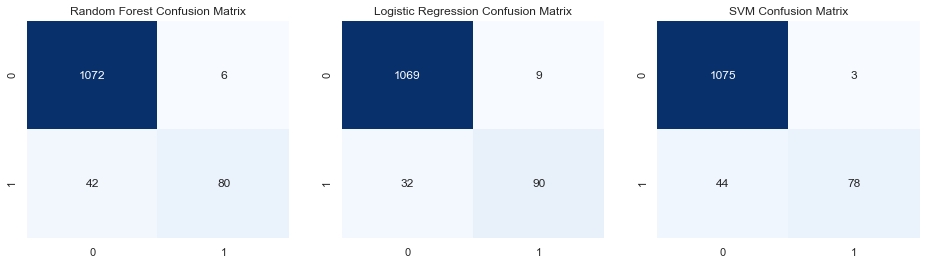

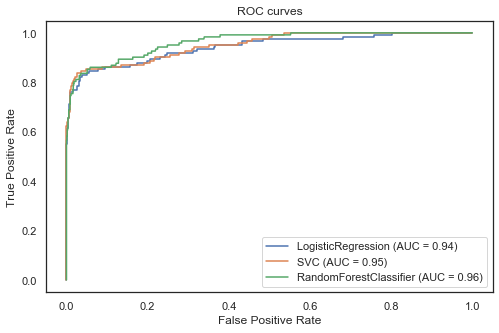

In [24]:
sns.set_style('white')
# Prepare test set.
x_test_prepared = preprocessor.fit_transform(x_test)

# Make prediction on test dataset.
y_pred_lr = lr.predict(x_test_prepared)
y_pred_svc = svc.predict(x_test_prepared)
y_pred_rf = rf.predict(x_test_prepared)

lr_cm = confusion_matrix(y_test, y_pred_lr)
svc_cm = confusion_matrix(y_test, y_pred_svc)
rf_cm = confusion_matrix(y_test, y_pred_rf)

f, axes = plt.subplots(1,3, figsize=(16,4))

axes[0].set_title('Random Forest Confusion Matrix')
sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axes[0])

axes[1].set_title('Logistic Regression Confusion Matrix')
sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axes[1])

axes[2].set_title('SVM Confusion Matrix')
sns.heatmap(svc_cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axes[2])

g, ax = plt.subplots(figsize=(8,5))
ax.set_title('ROC curves')
plot_roc_curve(lr, x_test_prepared, y_test, ax=ax)
plot_roc_curve(svc, x_test_prepared, y_test, ax=ax)
plot_roc_curve(rf, x_test_prepared, y_test, ax=ax)


plt.show()

* Random forest has highest (ROC) score 96%.
* All three classifiers have high precisions for majority class that is they classify very well non fradulent transactions. 
* But they have low recall for minority class, they are less succesful to classify fradulent transactions. 
* Logistic Regression has highest recall for minority class (recall = $\frac{TP}{TP+FP} = \frac{90}{90+32}=0.74$).

In [25]:
for classifier in [lr, svc, rf]:
    print('Recall score for', classifier.__class__.__name__ , '{:.4f}'
          .format(recall_score(y_test, classifier.predict(x_test_prepared))))

Recall score for LogisticRegression 0.7377
Recall score for SVC 0.6393
Recall score for RandomForestClassifier 0.6557


Next we will look if oversampling would improve recall score for minoraty class.

### Logistic Regression on oversampled data

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class. Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling Technique, or SMOTE for short. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [26]:
from imblearn.over_sampling import SMOTE

x_train_upsample, y_train_upsample = SMOTE(sampling_strategy=1,
    random_state=42).fit_resample(x_train_prepared, y_train)

In [27]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
sm = SMOTE(sampling_strategy=1, random_state=42)

def model_score(model, params):
    scores = []
    for fold, (train_index, val_index) in enumerate(
            sss.split(x_train, y_train), 1):
        x_train_fold = x_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        x_val_fold = x_train.iloc[val_index]
        y_val_fold = y_train.iloc[val_index]
        x_train_fold = preprocessor.fit_transform(x_train_fold)
        x_train_fold_upsample, y_train_fold_upsample = sm.fit_resample(
            x_train_fold, y_train_fold)
        moedel_obj = model(**params).fit(x_train_fold_upsample, 
                                         y_train_fold_upsample)
        x_val_fold = preprocessor.fit_transform(x_val_fold)
        score = roc_auc_score(y_val_fold, moedel_obj.decision_function(x_val_fold))
        scores.append(score)
    return np.array(scores)

In [28]:
exemple_params = {'solver': 'liblinear',
                  'penalty': 'l1', 
                  'C': 0.1}

model_score(LogisticRegression, exemple_params)

array([0.93041601, 0.92606633, 0.89918058, 0.91041775, 0.91798166])

In [29]:
lr_params = {'solver': ['liblinear'],
             'penalty': ['l1','l2'], 
             'C': [0.0001, 0.001, 0.01, 0.1, 1]}

In [30]:
score_tracker = []
for solver in lr_params['solver']:
    for penalty in lr_params['penalty']:
        for C in lr_params['C']:
            example_params = {
                'solver': solver,
                'penalty': penalty,
                'C': C
            }
            example_params['roc_auc_score'] = model_score(LogisticRegression, 
                                               example_params).mean()
            score_tracker.append(example_params)

Now we can look at the best hyperparameters.

In [31]:
max(score_tracker, key=lambda x: x['roc_auc_score'])

{'solver': 'liblinear',
 'penalty': 'l1',
 'C': 0.1,
 'roc_auc_score': 0.9168146572522782}

(ROC) score on oversampled data is 0.92. Next we will train the model with this hyperparameters on oversampled data.

In [32]:
lr_upsample = LogisticRegression(solver='liblinear', penalty='l1', C=0.1)
lr_upsample.fit(x_train_upsample, y_train_upsample)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

Let's see the performance of this model on test set.

In [33]:
y_pred_smote = lr_upsample.predict(x_test_prepared)

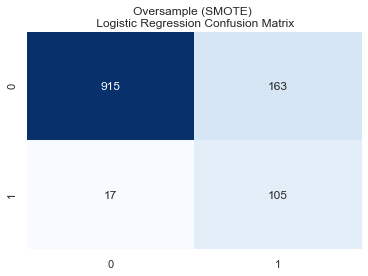

In [34]:
lr_smote_cm = confusion_matrix(y_test, y_pred_smote)

plt.title('Oversample (SMOTE) \n Logistic Regression Confusion Matrix')
sns.heatmap(lr_smote_cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.show()

As it was expected the recall of minority class has improved.

## Conclusion

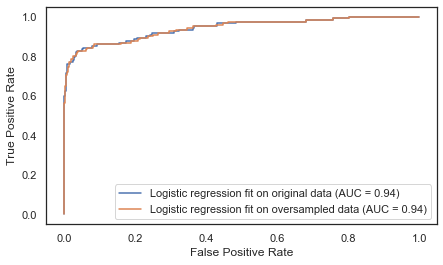

Recall score of logistic regression fit on original data: 0.7377
Recall score of logistic regression fit on oversampled data: 0.8607


In [35]:
fig, ax = plt.subplots(figsize=(7,4))

plot_roc_curve(lr, x_test_prepared, y_test, 
               name='Logistic regression fit on original data', ax=ax)
plot_roc_curve(lr_upsample, x_test_prepared, y_test, 
               name='Logistic regression fit on oversampled data', ax=ax)
plt.show()

print('Recall score of logistic regression fit on original data: {:.4f}'
    .format(recall_score(y_test, y_pred_lr)))
print('Recall score of logistic regression fit on oversampled data: {:.4f}'
    .format(recall_score(y_test, y_pred_smote)))

* Both models have 94% (ROC) test scores but the recall score of minority class has improved to from 73% to 86%. 

* The first model has higher accuracy, however, the nature of the application requires a fairly high rate of correct detection in the minority class and allows for a small error rate in the majority class in order to achieve this.

* The results show that the SMOTE approach can improve the accuracy of classifiers for a minority class.

                                                    END